# Viscous flow about moving bodies
In this notebook we will demonstrate the simulation of a system of moving bodies.
As we will show, it is straightforward to set up a moving body, using the
tools in [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).
The main caveat is that the simulation is slower,
because the integrator must update the operators continuously throughout the simulation.

We will demonstrate this on a system of three linked plates undergoing a flapping
motion, in which the middle plate heaves up and down, and the other two
bodies pitch back and forth on hinges connecting their edges to the middle plate.

In [1]:
using ViscousFlow

In [2]:
using Plots

### Problem specification and discretization
For simplicity, we will not create a free stream in this problem. Everything
here is the usual.

In [3]:
my_params = Dict()
my_params["Re"] = 200

200

In [4]:
xlim = (-1.0,1.0)
ylim = (-1.0,1.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)

0.027999999999999997

### Set up body
Set up the plates.

In [5]:
body1 = Plate(0.5,Δs)
body2 = Plate(0.5,Δs)
body3 = Plate(0.5,Δs)
bl = BodyList([body1,body2,body3])

BodyList(Body[Open polygon with 2 vertices and 18 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, Open polygon with 2 vertices and 18 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, Open polygon with 2 vertices and 18 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
])

### Set the body motions
Here, we make use of joints to prescribe the motion of every part of this system.
We will attach body 1 to the inertial system, making it oscillate up and down.
This is a special case of a joint with three degrees of freedom, called a `FreeJoint2d`.
Bodies 2 and 3 will each be connected by hinges (i.e., with a `RevoluteJoint`)
to body 1.

First, specify joint 1, attaching body 1 to the inertial system (body 0). We need
a more detailed form of the `Joint` function now. In this form, we need
to specify how the joint is attached to each body, and how each of its
degrees of freedom move. We will do this piece by piece to explain it.
More details can be found in the documentation for [RigidBodyTools.jl](https://github.com/JuliaIBPM/RigidBodyTools.jl).

In [6]:
parent_body, child_body = 0, 1
Xp = MotionTransform([0,0],0) # location of joint in inertial system
xpiv = [0,0] # place center of motion at center of the plate
Xc = MotionTransform(xpiv,0)

2d motion transform, x = [0.0, 0.0], R = [1.0 -0.0; 0.0 1.0]

Now the motion for joint 1, which we set up through the three degrees of freedom.
The degrees of freedom are ordered `[rotation, x, y]`. The first and second
are meant to be fixed, so we give them zero velocity, and the third
we assign oscillatory kinematics

In [7]:
adof = ConstantVelocityDOF(0.0)
xdof = ConstantVelocityDOF(0.0)

ω = 1
A = 0.25  # amplitude/chord
ϕh = 0.0  # phase lag of heave
ydof = OscillatoryDOF(A,ω,ϕh,0.0)

dofs = [adof,xdof,ydof]

3-element Vector{AbstractPrescribedDOFKinematics}:
 Constant velocity kinematics (velocity = 0.0)
 Constant velocity kinematics (velocity = 0.0)
 Oscillatory kinematics (amplitude = 0.25, ang freq = 1.0, phase = 0.0, mean velocity = 0.0)

Now assemble the joint

In [8]:
joint1 = Joint(FreeJoint2d,parent_body,Xp,child_body,Xc,dofs)

Joint of dimension 2 and type FreeJoint2d
   Constrained dofs = [1, 2, 3]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


Now the two hinges. Each of these is a `RevoluteJoint`. We place them
at either end of body 1. Joint 2 between bodies 1 and 2

In [9]:
parent_body, child_body = 1, 2
Xp = MotionTransform([0.25,0],0) # right side of body 1
Xc = MotionTransform([-0.25,0],0) # left side of body 2
Δα = 20π/180 # amplitude of pitching
ϕp = π/2 # phase lag of pitch
θdof = OscillatoryDOF(Δα,ω,ϕp,0.0)
joint2 = Joint(RevoluteJoint,parent_body,Xp,child_body,Xc,[θdof])

Joint of dimension 2 and type RevoluteJoint
   Constrained dofs = [1]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


and joint 3 between bodies 1 and 3

In [10]:
parent_body, child_body = 1, 3
Xp = MotionTransform([-0.25,0],0) # left side of body 1
Xc = MotionTransform([0.25,0],0) # right side of body 3
Δα = -20π/180 # amplitude of pitching
ϕp = -π/2 # phase lag of pitch
θdof = OscillatoryDOF(Δα,ω,ϕp,0.0)
joint3 = Joint(RevoluteJoint,parent_body,Xp,child_body,Xc,[θdof])

Joint of dimension 2 and type RevoluteJoint
   Constrained dofs = [1]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


Assemble everything together

In [11]:
m = RigidBodyMotion([joint1,joint2,joint3],bl)

1 linked system(s) of bodies
   3 bodies
   3 joints


We generate the initial joint state vector with `init_and update the body system and plot it

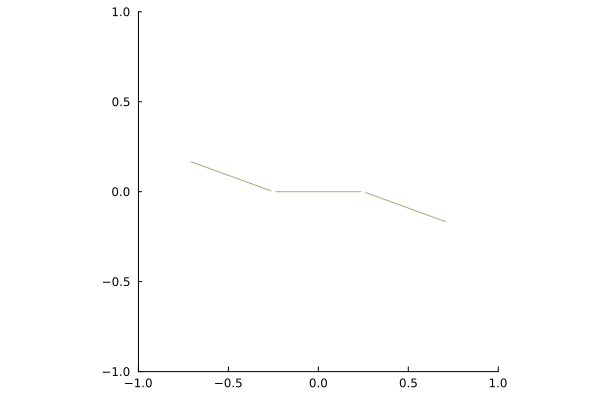

In [12]:
x = init_motion_state(bl,m)
update_body!(bl,x,m)
plot(bl,xlim=xlim,ylim=ylim)

Here is a useful macro to visualize the motion as a movie:

```macro animate_motion(b,m,dt,tmax,xlim,ylim)
    return esc(quote
            bc = deepcopy($b)
            t0, x0 = 0.0, init_motion_state(bc,$m)
            dxdt = zero(x0)
            x = copy(x0)

            @gif for t in t0:$dt:t0+$tmax
                motion_rhs!(dxdt,x,($m,bc),t)
                global x += dxdt*$dt
                update_body!(bc,x,$m)
                plot(bc,xlim=$xlim,ylim=$ylim)
            end every 5
        end)
end
```

### Define the boundary condition functions
Instead of using the default boundary condition functions, we define
special ones here that provide the instantaneous surface velocity (i.e. the velocity
of every surface point) from the prescribed
motion. Every surface has an "exterior" and "interior" side. For
a flat plate, these two sides are the upper and lower sides, and both sides
are next to the fluid, so both of them are assigned the prescribed velocity
of the plate. (For closed bodies, we would assign this velocity to only
one of the sides, and zero to the other side. We will see an example of this in a later case.)
We pack these into a special dictionary and
pass these to the system construction.

In [13]:
function my_vsplus(t,x,base_cache,phys_params,motions)
  vsplus = zeros_surface(base_cache)
  surface_velocity!(vsplus,x,base_cache,motions,t)
  return vsplus
end

function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  surface_velocity!(vsminus,x,base_cache,motions,t)
  return vsminus
end

bcdict = Dict("exterior" => my_vsplus, "interior" => my_vsminus)

Dict{String, Function} with 2 entries:
  "interior" => my_vsminus
  "exterior" => my_vsplus

### Construct the system structure
Here, we supply both the motion and boundary condition functions as additional arguments.

In [14]:
sys = viscousflow_system(g,bl,phys_params=my_params,motions=m,bc=bcdict);

and generate the initial condition

In [15]:
u0 = init_sol(sys)

(Dual nodes in a (nx = 110, ny = 110) cell grid of type Float64 data
  Number of Dual nodes: (nx = 110, ny = 110), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.3490658503988659, -0.3490658503988659])

Before we solve the problem, it is useful to note that the Reynolds number
we specified earlier may not be the most physically-meaningful Reynolds number.
More relevant in this problem is the Reynolds number based on the maximum
body speed and the total length of the plates

In [16]:
Umax, imax, tmax, bmax = maxvelocity(u0,sys)
L = 3*0.5
Re_eff = my_params["Re"]*Umax*L

89.46101830654776

In [17]:
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 110, ny = 110) cell grid of type Float64 data
  Number of Dual nodes: (nx = 110, ny = 110), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, -0.3490658503988659, -0.3490658503988659])

### Solve
This takes longer per time step than it does for stationary bodies. Here, we only
run it for 1.5 time units just to demonstrate it.

In [18]:
@time step!(integrator,1.5)

 36.253925 seconds (30.67 M allocations: 13.183 GiB, 1.01% gc time, 13.33% compilation time)


### Examine the solution
Let's look at a few snapshots of the vorticity field. Note that the
plotting here requires us to explicitly call the `surfaces`
function to generate the instantaneous configuration of the plate.

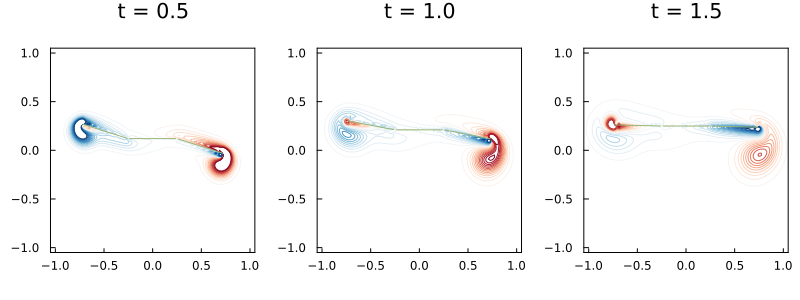

In [19]:
sol = integrator.sol
plt = plot(layout = (1,3), size = (800, 300), legend=:false)
tsnap = 0.5:0.5:1.5
for (i, t) in enumerate(tsnap)
    plot!(plt[i],vorticity(sol,sys,t),sys,layers=false,title="t = $(round(t,digits=2))",clim=(-5,5),levels=range(-5,5,length=30),color = :RdBu)
    plot!(plt[i],surfaces(sol,sys,t))
end
plt

and the forces

In [20]:
sol = integrator.sol
fx, fy = force(sol,sys,1);

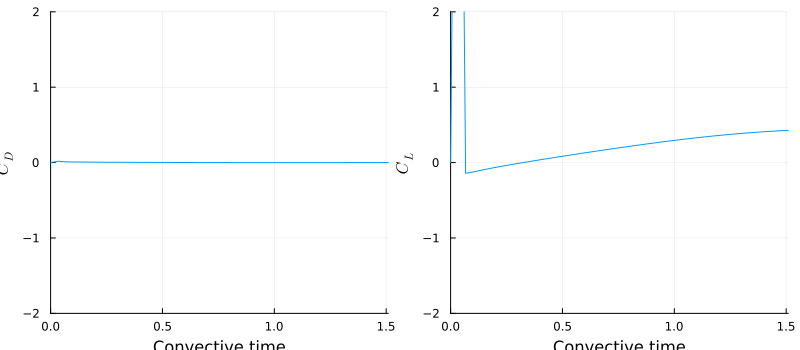

In [21]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
    size=(800,350)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*